# introai202401-midterm-JGu-K

소프트웨어학과 202020865 김준규

## Prerequisites


In [179]:
%pip install torch torchvision torchinfo pytorchcv matplotlib pytorchsummary torchmetrics

from torchinfo import summary

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.optim as optim

default_device = 'cuda' if torch.cuda.is_available() else 'cpu' #사용 가능한 경우 CUDA를 사용하고, 그렇지 않으면 CPU를 사용하도록 설정
print(default_device)

Note: you may need to restart the kernel to use updated packages.
cpu


## 데이터 분석
### torchvision module에서 제공하는 FashionMNIST를 활용해야 합니다 (전체 데이터)

`data_train`과 `data_test`에 데이터셋을 로드합니다.

전역 변수 설정해 아래 셀들에서 액세스할 수 있도록 했습니다.

In [180]:
def load_FashionMNIST(batch_size=64):
    global data_train
    global data_test
    global train_loader
    global test_loader

    data_train = torchvision.datasets.FashionMNIST('./data', download=True,train=True,transform=ToTensor())
    data_test = torchvision.datasets.FashionMNIST('./data', download=True,train=False,transform=ToTensor())
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)

load_FashionMNIST(batch_size=128) 

### 이미지 데이터의 형태와 클래스 레이블을 시각적으로 탐색하고 분석합니다.

데이터셋의 항목 중 일부를 라벨과 함께 표 형식으로 출력했습니다.\
FashionMNIST의 데이터셋은 흑백 이미지이기 때문에 `cmap`을 gray로 설정했습니다. 

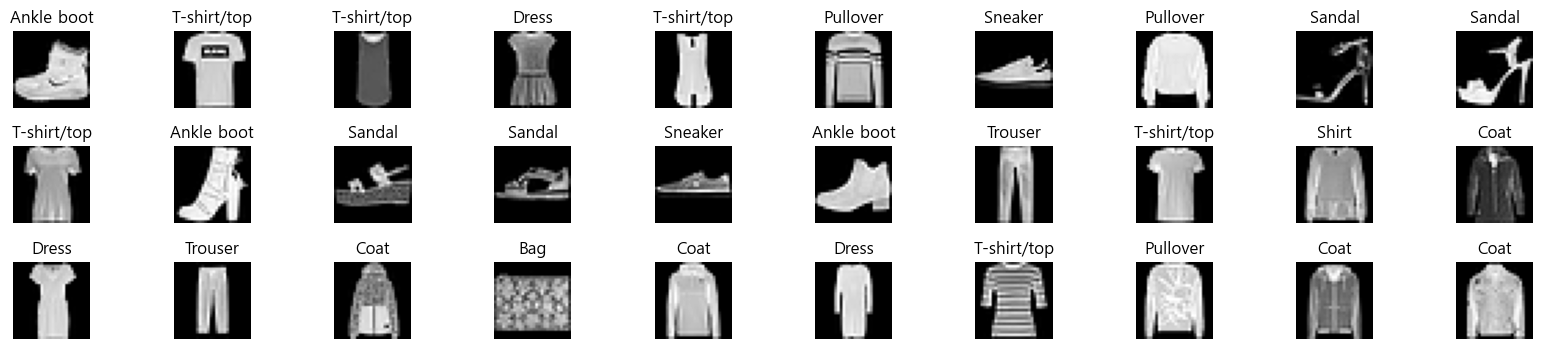

In [181]:
# 한 행당 이미지 개수
images_per_row = 10
num_rows = 3
total_images = images_per_row * num_rows

# 그림의 크기 설정
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 4))

# 처음 30개의 항목을 표 형식으로 표시
for i, ax in enumerate(axes.flat):
    image, label = data_train[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(data_train.classes[label])
    ax.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()


## 모델 구축 및 훈련
### 간단한 CNN 모델을 구축합니다. 모델은 적어도 한 개의 컨볼루션 레이어와 풀링 레이어를 포함해야 합니다.

다음 `OneConv`는 한 개의 컨볼루션 레이어와 풀링 레이어를 포함하는 CNN 모델의 클래스 표현입니다.

pytorch의 모든 신경망 모듈의 기본 클래스인 `nn.Module`을 상속받아 진행합니다.

In [182]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5)) # 입력 채널이 1개, 출력 채널이 9개인 2D 컨볼루션 레이어를 정의하고, 이를 객체의 conv 속성으로 할당
        self.flatten = nn.Flatten()                                           # 다차원 입력을 1차원 배열로 변환하는 Flatten 레이어를 정의하고, flatten 속성으로 할당
        self.fc = nn.Linear(5184,10)                                          # 5,184개의 입력 특성을 10개의 출력 특성으로 변환하는 완전 연결 레이어(또는 선형 레이어)를 정의하고, fc 속성으로 할당

    # 모델의 순전파를 정의하는 메서드로, 입력 데이터가 모델을 통과하는 과정을 설명
    def forward(self, x):
        if x.dim() == 5 and x.size(2) == 1:             # 입력 x의 차원이 예상치 못한 추가 차원을 포함하는 경우, 해당 차원을 제거
            x = x.squeeze(2)

        x = nn.functional.relu(self.conv(x))            # 정의된 컨볼루션 레이어를 입력 x에 적용한 후 ReLU 활성화 함수를 적용
        x = self.flatten(x)                             # ReLU의 출력을 flatten 레이어를 통해 평탄화
        x = nn.functional.log_softmax(self.fc(x),dim=1) # 평탄화된 벡터를 fc 레이어에 적용하고, 결과를 다중 클래스 분류 문제에 대한 확률을 계산할 때 사용하기 위해 로그 소프트맥스 함수를 통해 처리

        return x

    
net = OneConv()

# 생성된 모델의 요약 정보 출력
summary(net,input_size=(1,1,28,28)) # input_size: 모델이 기대하는 입력 데이터의 크기를 (채널 수, 높이, 너비) 형식으로 지정

Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Linear: 1-3                            [1, 10]                   51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

### 모델을 컴파일하고, 적절한 손실 함수와 최적화 알고리즘을 선택합니다.

가능한 경우 CUDA 활성화를 활성합니다.

Adam을 이용하는 최적화 알고리즘을 선택하고 다중 클래스 분류를 하는 문제이므로 크로스 엔트로피 손실 함수를 사용합니다.

In [183]:
device = torch.device(default_device)               # 위에서 설정한 기본 장치 설정
net.to(device)                                      # 모델을 해당 장치로 이동
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Adam 최적화 도구를 사용하여 모델의 매개변수를 최적화하고, 학습률은 0.001로 설정
criterion = torch.nn.CrossEntropyLoss()             # 다중 클래스 분류를 위한 크로스 엔트로피 손실 함수를 사용

### 훈련 데이터를 사용하여 모델을 훈련시키고, 훈련 과정에서의 손실과 정확도를 모니터링합니다.

아래 함수는 지정된 에폭 수만큼 반복하면서 모델의 훈련 및 평가를 수행합니다.

학습 시에는 model.train()을 호출하여 모델을 학습 모드로 설정하고, 평가 시에는 model.eval()을 호출하여 평가 모드로 설정합니다.\
동시에 손실과 정확도를 history 딕셔너리에 담아 반환합니다.

In [184]:
def train(model, train_loader, test_loader, epochs=5):
    model.to(device)
    
    # 손실과 정확도를 기록할 딕셔너리
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    
    try:
        for epoch in range(epochs):
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0

            # 데이터와 타겟을 장치로 이동시킨 후, 최적화 도구를 이용해 그래디언트를 초기화하고, 모델을 통해 예측을 수행
            for data, target in train_loader:                               
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
                # 손실을 계산하고, 역전파를 통해 그래디언트를 계산한 다음, 최적화 도구로 매개변수를 업데이트
                loss = criterion(output, target)
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                loss.backward()
                optimizer.step()
                
                # 정확도와 손실을 기록하여 진행 상황을 모니터링
                train_loss += loss.item()                                     
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            # 훈련 데이터셋에 대한 손실과 정확도 계산
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
            # 테스트 과정도 같은 에포크 안에 수행
            model.eval()
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            # 테스트 데이터셋에 대한 손실과 정확도 계산
            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
    except Exception as e: # 에러 처리
        print(f"An error occurred: {e}")
        return None
    
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환

In [185]:
# 10 epoch 동안 학습을 수행하고 학습 과정에서 계산된 손실과 정확도 같은 통계 정보를 hist 변수에 저장
hist = train(net, train_loader, test_loader, epochs=10)

Epoch 1/10: Train Loss: 0.0041, Train Acc: 81.75%, Test Loss: 0.0034, Test Acc: 84.62%
Epoch 2/10: Train Loss: 0.0029, Train Acc: 87.02%, Test Loss: 0.0030, Test Acc: 86.76%
Epoch 3/10: Train Loss: 0.0026, Train Acc: 88.34%, Test Loss: 0.0030, Test Acc: 86.95%
Epoch 4/10: Train Loss: 0.0024, Train Acc: 89.12%, Test Loss: 0.0028, Test Acc: 87.63%
Epoch 5/10: Train Loss: 0.0023, Train Acc: 89.75%, Test Loss: 0.0027, Test Acc: 88.17%
Epoch 6/10: Train Loss: 0.0022, Train Acc: 90.19%, Test Loss: 0.0027, Test Acc: 88.32%
Epoch 7/10: Train Loss: 0.0021, Train Acc: 90.64%, Test Loss: 0.0027, Test Acc: 88.34%
Epoch 8/10: Train Loss: 0.0020, Train Acc: 90.95%, Test Loss: 0.0026, Test Acc: 88.48%
Epoch 9/10: Train Loss: 0.0019, Train Acc: 91.29%, Test Loss: 0.0026, Test Acc: 88.59%
Epoch 10/10: Train Loss: 0.0019, Train Acc: 91.54%, Test Loss: 0.0026, Test Acc: 88.64%


## 모델 평가 및 결과 분석
### 테스트 데이터셋을 사용하여 모델을 평가하고, 최종 정확도를 보고합니다.

테스트 데이터셋을 이용한 모델 평가는 위 항목에서 훈련 데이터셋과 함께 이루어졌습니다.

10번의 Epoch로 확인할 수 있는 최종 정확도는 89%입니다.\
아래는 훈련과 테스트 데이터셋과의 시각적 비교를 위한 그래프입니다.

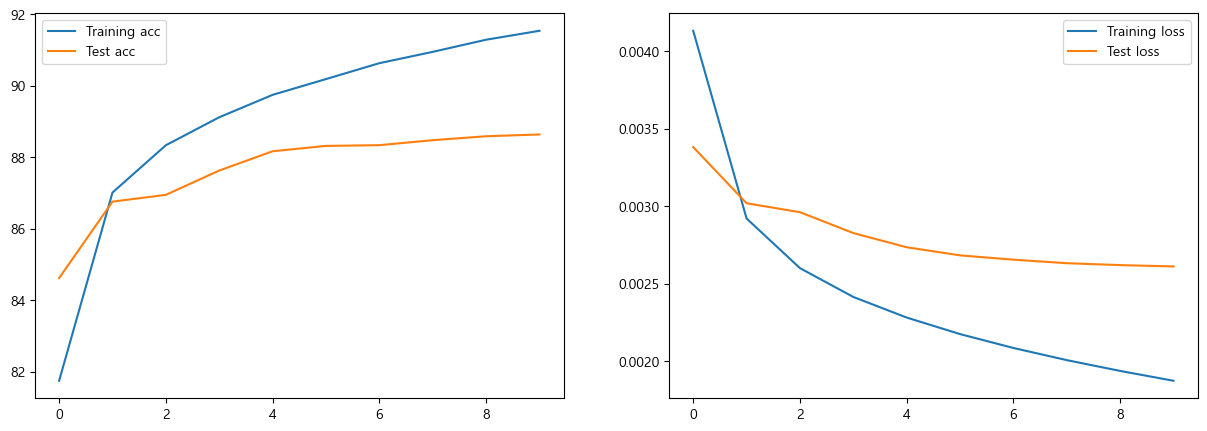

In [186]:
# 학습과 검증 과정의 정확도와 손실을 그래프로 나타내는 함수
def plot_results_fix(hist):
    plt.figure(figsize=(15,5))
    
    plt.subplot(121)                                        # 두 개의 그래프를 나란히 표시하기 위해 첫 번째 위치(1행 2열의 첫 번째)에 서브플롯을 생성
    plt.plot(hist['train_acc'], label='Training acc')       # 학습 정확도를 그래프화
    plt.plot(hist['test_acc'], label='Test acc')            # 검증 정확도를 그래프화
    plt.legend()                                            # 그래프에 범례 추가
    
    plt.subplot(122)                                        # 두 번째 위치(1행 2열의 두 번째)에 또 다른 서브플롯을 생성
    plt.plot(hist['train_loss'], label='Training loss')     # 학습 손실을 그래프화
    plt.plot(hist['test_loss'], label='Test loss')          # 검증 손실을 그래프화
    plt.legend()

# 학습 결과 딕셔너리가 올바를 시 그래프 생성
if hist is None:
    print("Training did not return any history.")
else:
    plot_results_fix(hist)

### 잘못 분류된 이미지들을 분석하고, 어떤 클래스가 모델에 의해 가장 잘못 분류되었는지를 식별합니다.

아래 코드는 잘못 분석된 이미지들을 분석해 각 클래스 별로 그 횟수를 나타내는 그래프입니다.

그래프에 따르면 `T-shirt/top` 클래스가 가장 많이 잘못 분류되었다는 것을 알 수 있습니다.

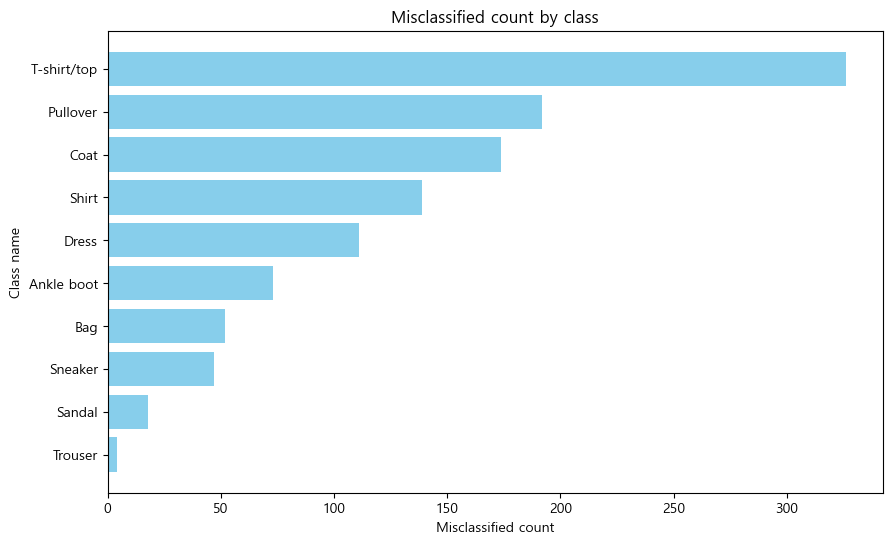

In [187]:
def analyze_misclassified_images(model, test_loader, classes, device):
    model.eval()
    misclassified_counts = {class_name: 0 for class_name in classes}

    with torch.no_grad():
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            
            # 각 이미지에 대해 예측이 실제와 다른 경우를 확인
            _, predicted = torch.max(outputs, 1)
            misclassified_mask = predicted != targets
            misclassified_classes = predicted[misclassified_mask].cpu().tolist()

            for class_idx in misclassified_classes:
                class_name = classes[class_idx]
                misclassified_counts[class_name] += 1
    
    # 그래프를 내림차순 정렬하기 위해 값을 정렬
    sorted_misclassified_counts = sorted(misclassified_counts.items(), key=lambda x: x[1], reverse=False)
    
    # 그래프 생성
    plt.figure(figsize=(10, 6))
    plt.barh([class_name for class_name, count in sorted_misclassified_counts], 
             [count for class_name, count in sorted_misclassified_counts], 
             color='skyblue')    
    plt.xlabel('Misclassified count')
    plt.ylabel('Class name')
    plt.title('Misclassified count by class')
    plt.show()

analyze_misclassified_images(net, test_loader, data_train.classes, device)